In [1]:
from graphs.my_graph import graphs # my custom dataviz environment
mg = graphs('notebook') # initialize a visualization env optimize for notebook display
import numpy as np

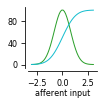

In [12]:
from data_analysis.signal_library.classical_functions import gaussian, gaussian_cumproba
mg = graphs('manuscript') # initialize a visualization env optimize for notebook display
x = np.linspace(-3,3)
fig, ax = mg.figure(with_legend_space=True)
mg.plot(x, 100.*gaussian(x, std=0.8)/np.max(gaussian(x, std=0.8)), ax=ax, no_set=True, color=mg.g)
mg.plot(x, 100.*gaussian_cumproba(x), ax=ax, no_set=True, color=mg.cyan)
mg.set_plot(ax, xlabel='afferent input', ylabel=)

In [8]:
mg.figure?